### Importing dependencies

In [1]:
# tools and utilities
import re
import pickle
import jieba
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# font for Chinese word-cloud
font = r'./QingNiaoHuaGuangJianMeiHei-2.ttf'

# sklearn kits
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

### Importing dataset

In [2]:
# reading the dataset
df = pd.read_csv('./wuhan_sentiment.csv')
df.head()

,Unnamed: 0,text,sentiment_label,sentiment_key,positive_probs,negative_probs
0,0,【感染诺如病毒该如何应对？】诺如病毒是一组形态相似、抗原性略有不同的病毒颗粒，主要表现为腹泻...,0,negative,0.0064,0.9936
1,1,【多部门联手打击“炒猪团” ，保障生猪产品质量安全】最近一段时间，在部分地区出现了“炒猪团”...,0,negative,0.0025,0.9975
2,2,【健康科普】流感风暴来袭，这份秘籍必须收好了！近日，国家流感中心发布最新数据，截至2019年...,1,positive,0.9668,0.0332
3,3,#微博萧县#【我县多举措激活生猪养殖业】今年以来，萧县把扶持生猪生产作为落实民生“菜篮子”工...,0,negative,0.0077,0.9923
4,4,【农业农村部：加快恢复生猪生产】览富财经12月30日讯，农业农村部副部长表示，加快恢复生猪生...,0,negative,0.0063,0.9937


In [3]:
# dropping na values
print(df.isna().sum())
df.dropna(inplace=True)

# turn sentiment_label column into integer type
# turn sentiment_key column into String type
df['sentiment_label'] = df['sentiment_label'].astype(int)
df['sentiment_key'] = df['sentiment_key'].astype(str)

# select all rows with sentiment_label =0 or 1
# select all rows with sentiment_key = positive or negative
df_cleaned = df[df['sentiment_label'].isin([0, 1]) &
                df['sentiment_key'].isin(['positive', 'negative'])][['text','sentiment_label', 'sentiment_key']]
# order sentiment_label column acendingly
df_cleaned.sort_values(by=['sentiment_label'], ascending=True, inplace=True)
df_cleaned.reset_index(inplace=True)
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

Unnamed: 0          0
text               20
sentiment_label    26
sentiment_key      26
positive_probs     26
negative_probs     32
dtype: int64


,text,sentiment_label,sentiment_key
0,【感染诺如病毒该如何应对？】诺如病毒是一组形态相似、抗原性略有不同的病毒颗粒，主要表现为腹泻...,0,negative
1,#坚决打赢疫情防控阻击战#【最新！蚌埠新增确诊病例1例情况公布】根据安徽省卫健委发布的最新疫...,0,negative
2,#武汉新型冠状病毒肺炎疫情防控# 【#钻石公主号中国同胞将乘包机返港#】2月19日起，“钻石...,0,negative
3,#武汉新型冠状病毒肺炎疫情防控# 【人社部引导农民工返工：#出家门上车门下车门进厂门#】人社...,0,negative
4,【总台记者探访：#武汉大型商超不再对个人开放#，市民如何买菜？】#武汉居民生活物资由社区统一...,0,negative
...,...,...,...
201828,【#为什么武汉新增病例高于湖北全省#？这个数据你需要看懂】今天湖北省疫情通报显示，湖北省新增...,1,positive
201829,【致敬英雄，黑龙江多家景区对全国医护人员免费开放】为向全国支援武汉的医护工作者致敬，黑龙江多...,1,positive
201830,#黑土巾帼抗疫情# 【视频--新冠病毒会长期存在吗？拐点来了吗？白岩松再次对话王辰】 在2...,1,positive
201831,【#整栋楼解封后业主高喊加油# 疫情过后你最想做什么？】疫情过后最想做什么？走出家门，把想吃...,1,positive


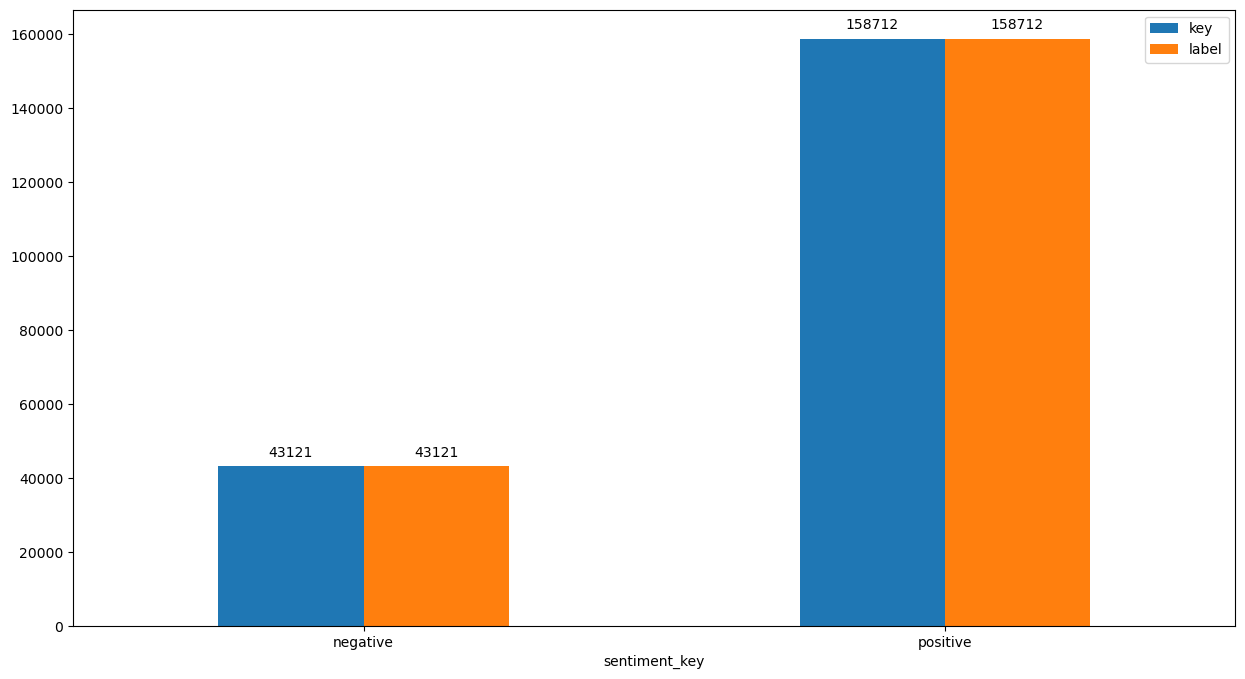

In [30]:
# Plotting the distribution for dataset
fig, ax = plt.subplots(figsize=(15,8))
ax = df_cleaned.groupby('sentiment_key').count().plot(kind='bar', ax=ax)
ax.set_xticklabels(['negative', 'positive'], rotation=0)
ax.legend(['key', 'label'])

# adding values to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Storing data in lists
text, sentiment = list(df_cleaned['text']), list(df_cleaned['sentiment_label'])

plt.show()

### Preprocess Text

In [6]:
# import baidu_stopwords.txt
# which is stopwords provided by baidu for Chinese context
# see here: https://github.com/goto456/stopwords
stopwordlist = []
with open('./baidu_stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        word = line.strip()
        if word:
            stopwordlist.append(word)
print(stopwordlist)

['--', '?', '“', '”', '》', '－－', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', "a's", 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', "c'mon", 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containin

In [8]:
def preprocess(textdata):
    processedText = []

    # regular expression to identify url and username(chinese)
    urlPattern = r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?"
    userPattern = r'@[\w\u4e00-\u9fa5]+'

    for tweet in textdata:
        # replace URLs and usernames
        tweet = re.sub(urlPattern, '提到某链接', tweet)
        tweet = re.sub(userPattern, '某用户', tweet)

        # user jieba to do word segmentation
        words = jieba.cut(tweet)

        tweetwords = []
        for word in words:
            # apply the stopwords offered by baidu
            if word not in stopwordlist and word.strip():
                tweetwords.append(word)

        processedText.append(' '.join(tweetwords))

    return processedText

In [9]:
import time

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')
processedtext[0] # for a quick glance of what one processed text look like

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/3d/bcwmv_7x7sn98y9ydfzp841m0000gn/T/jieba.cache
Loading model cost 0.375 seconds.
Prefix dict has been built successfully.


Text Preprocessing complete.
Time Taken: 678 seconds


'【 感染 诺如 病毒 应对 ？ 】 诺如 病毒 一组 形态 、 抗原性 略有不同 病毒 颗粒 ， 表现 腹泻 呕吐 ， 腹痛 、 恶心 、 头疼 、 发热 、 畏寒 症状 ， 国际 上 称之为 急性 胃肠炎 。 人体 感染 诺如 病毒 12 48 小时 内 症状 ， 病毒 导致 人患 急性 胃肠炎 ， 病情 轻微 ， 不必 过于 担心 ， 2 3 天 好转 ， 预后 ； 病情 较为 ， 患者 应 就医 ， 谨 遵 医嘱 。 感染 对象 成人 学龄儿童 ， 寒冷 季节 呈现 高发 。 学校 、 幼儿园 、 医院 、 养老院 人群 密集 场所 发生 聚集 性 疫情 ， 特别 5 岁 儿童 抵抗力 较差 ， 感染 。 诺如 病毒 急性 胃肠炎 特效药 物 ， 疫苗 ， 补液 对症 治疗 。 患者 应 休息 ， 清淡 饮食 。 诺如 病毒 传播 力较 强 ， 家中 诺 病毒 急性 胃肠炎 患者 家属 过分 亲密 接触 ， 传染给 家人 。 患者 排泄物 、 呕吐物 容器 、 餐饮具 含氯 消毒剂 重点 消毒 。 （ 来源 ： 顺义区 卫生 计划生育 委员会 ） 收起 全文 d'

### Analysing the data

##### Word-Cloud for negative tweets

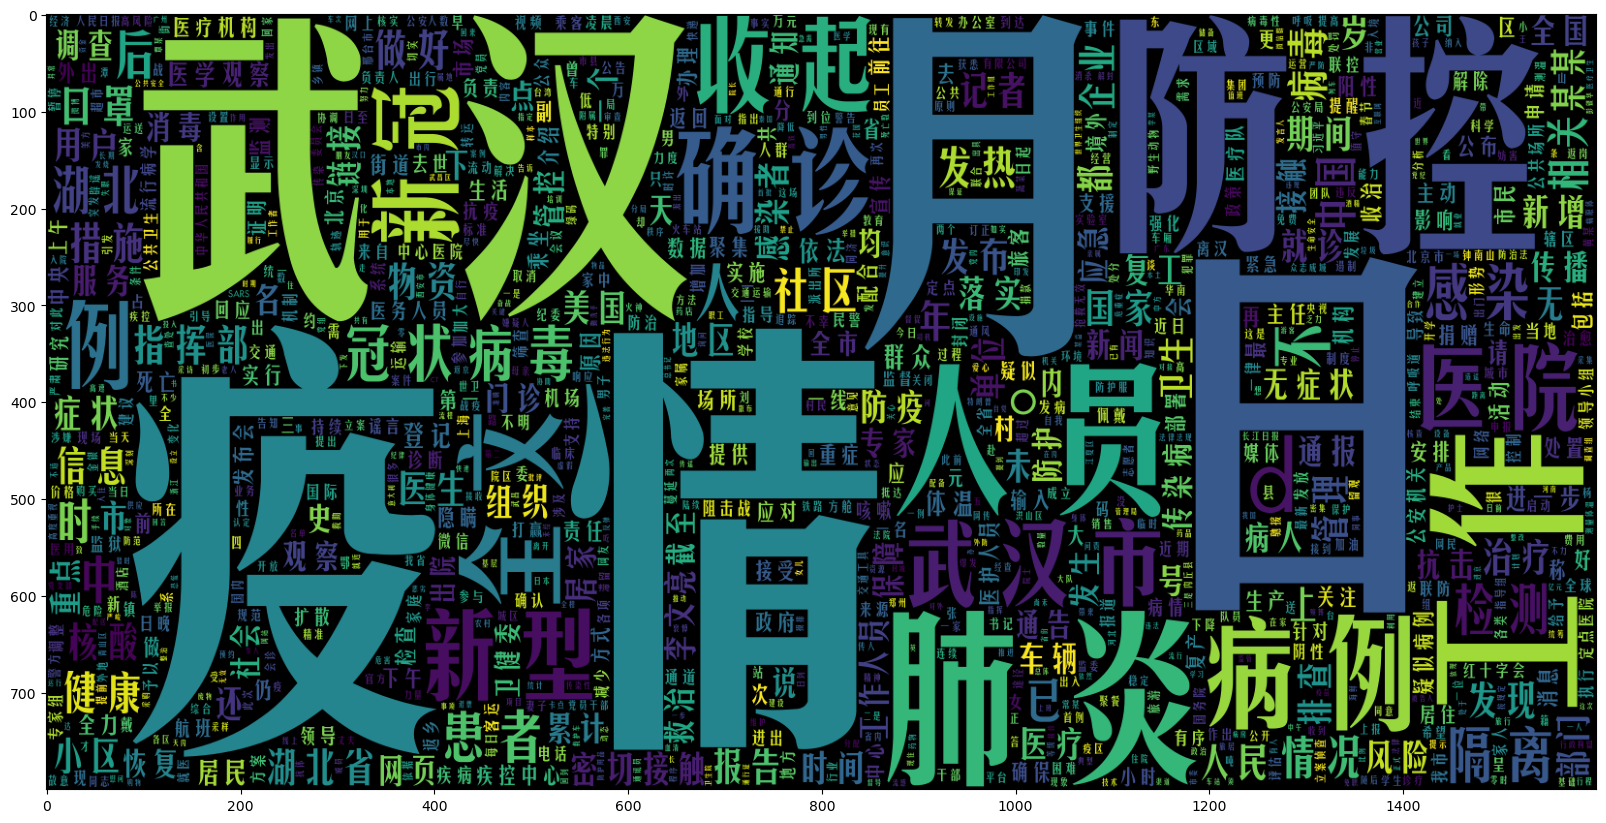

In [10]:
data_neg = processedtext[:43121]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, font_path=font,
               collocations=False).generate(" ".join(data_neg))
plt.grid(False)
plt.imshow(wc)

##### Word-Cloud for positive tweets

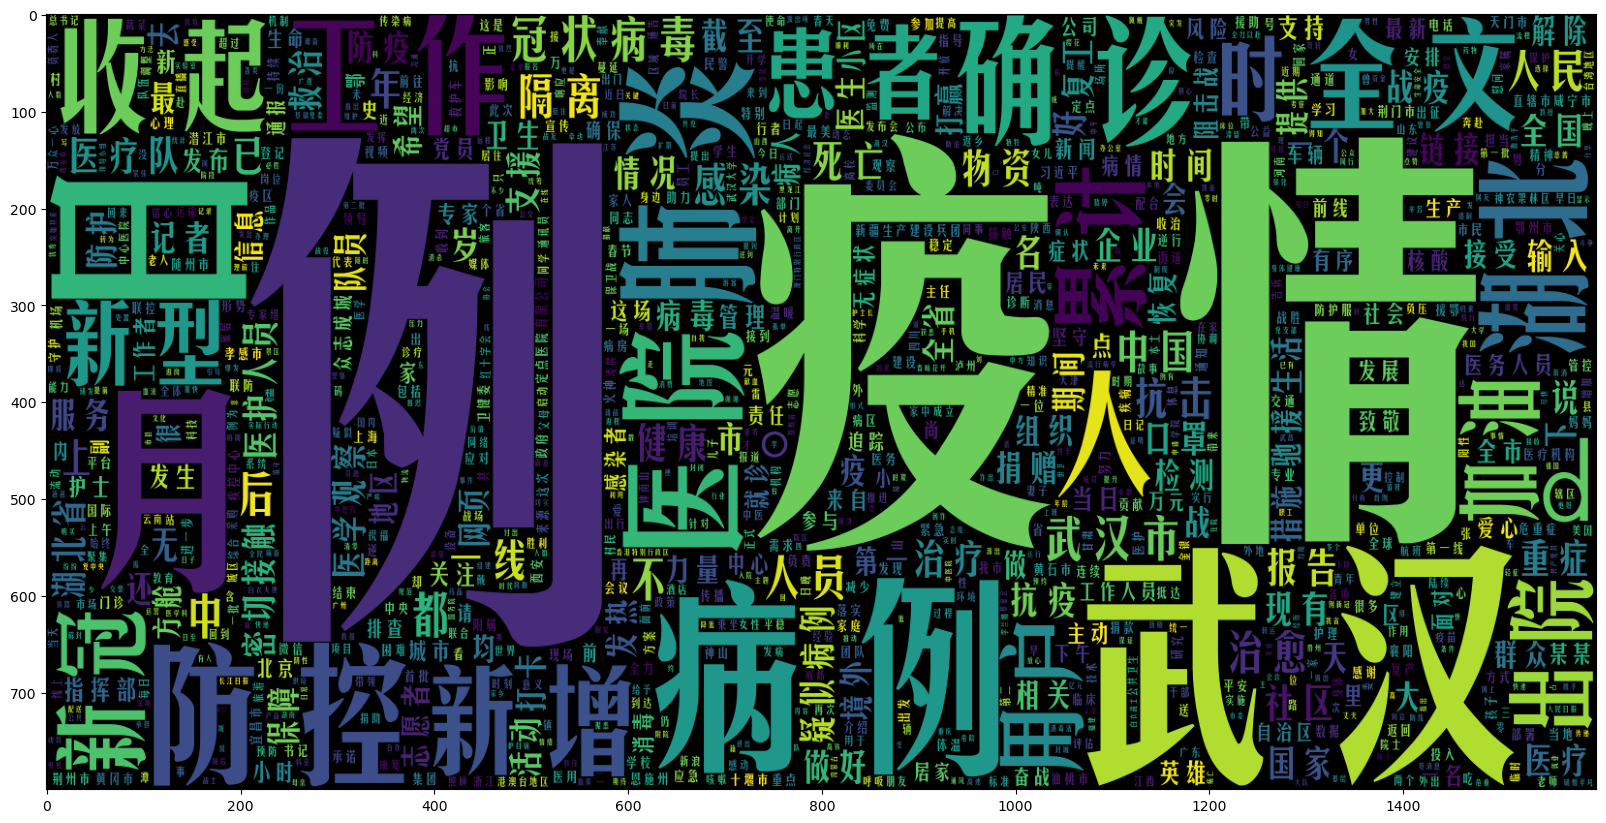

In [11]:
data_pos = processedtext[43121:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, font_path=font,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.grid(False)
plt.imshow(wc)

### Splitting the data

In [12]:
# restraint the data used, for a less skewed distribution
X_train, X_test, y_train, y_test = train_test_split(processedtext[:86242], sentiment[:86242],
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


### TF-IDF Vectoriser

In [13]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
print('fitting vectoriser')
t = time.time()
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print(f'Time Taken: {round(time.time()-t)} seconds')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

# transform the training and testing set
print('transforming datasets ~ X')
t = time.time()
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')
print(f'Time Taken: {round(time.time()-t)} seconds')

fitting vectoriser
Vectoriser fitted.
Time Taken: 16 seconds
No. of feature_words:  500000
transforming datasets ~ X
Data Transformed.
Time Taken: 10 seconds


### Creating and evaluating models

##### The function for model evaluation

In [14]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['negative','positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

##### Model 1: Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      2152
           1       0.82      0.93      0.87      2161

    accuracy                           0.86      4313
   macro avg       0.87      0.86      0.86      4313
weighted avg       0.87      0.86      0.86      4313



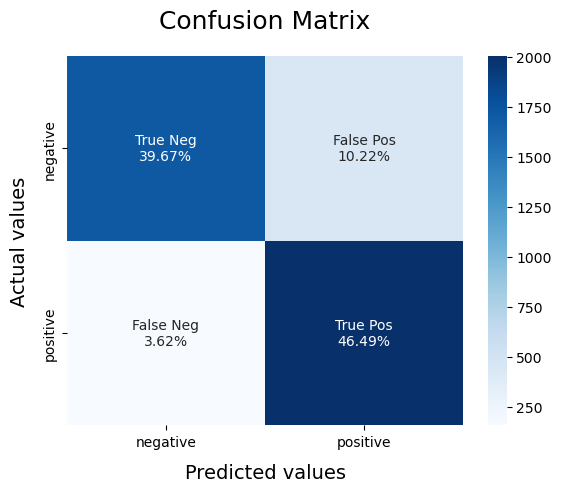

In [15]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

##### Model 2: Linear Support Vector Classification

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2152
           1       0.93      0.93      0.93      2161

    accuracy                           0.93      4313
   macro avg       0.93      0.93      0.93      4313
weighted avg       0.93      0.93      0.93      4313



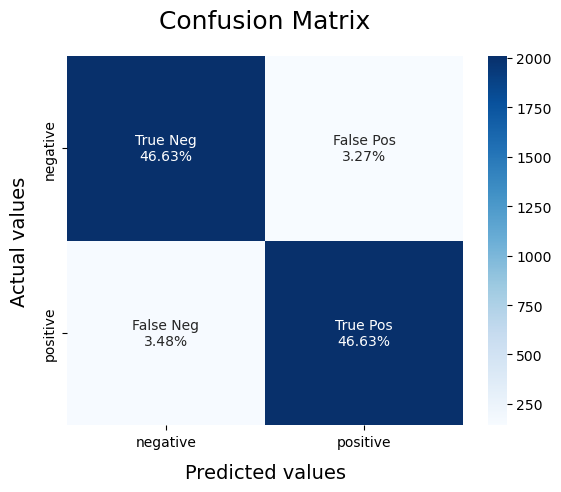

In [16]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

##### Model 3: Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2152
           1       0.92      0.92      0.92      2161

    accuracy                           0.92      4313
   macro avg       0.92      0.92      0.92      4313
weighted avg       0.92      0.92      0.92      4313



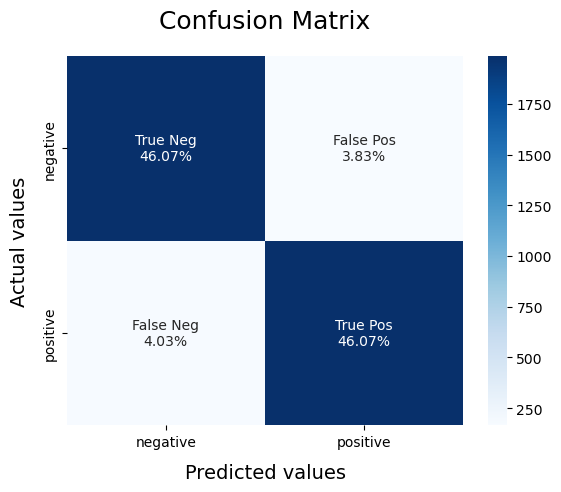

In [17]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

### Saving the models

In [18]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

### Using the Model

In [19]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''

    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()

    # Text to classify should be in a list.
    # Using AI to generate three news, respectively negative, positive and negative
    text = ["【武汉疫情形势：医疗物资短缺问题凸显】览富财经 2024 年 11 月 9 日讯，武汉部分医疗机构表示，随着新冠疫情的反复，医疗物资尤其是防护用品和特定药品的短缺问题日益严重。尽管各方努力调配资源，但目前仍有不少医院面临物资匮乏的困境。相关部门呼吁社会各界加大对武汉医疗物资的支援力度，以尽快缓解这一紧迫局面。",
            "武汉市卫健委关于新冠疫情防控的重大喜讯通报：专家高度赞誉武汉防控成就斐然，全城抗疫防线坚如磐石。目前，武汉市通过全面且高效的大规模疫苗接种、科学精准的防控策略以及全体市民的积极配合，已成功将新冠疫情牢牢控制。全市各个社区不仅实现了长时间的零感染，而且居民生活秩序井然，经济活动也在安全有序的环境中快速复苏。同时，医疗系统的应急响应能力达到了前所未有的高度，随时能够应对各种突发状况，为市民的生命健康提供了坚实保障。武汉，正以昂扬的姿态成为全球抗疫的典范城市。",
            "# 武汉新冠疫情反弹 #【武汉市卫健委通报疫情，局部地区疫情形势严峻复杂】据武汉市卫生健康委员会官网通报，近期武汉部分区域出现新冠疫情强烈反弹现象，尽管迅速采取了严格的管控措施，但新增病例仍在持续攀升。多个小区被列为高风险地区，居民被严格限制出行，生活陷入极大的困境。目前已发现疫情有向周边区域扩散的趋势，防控工作面临前所未有的巨大压力，且医疗资源紧张，部分患者无法得到及时有效的救治。到目前为止，疫情传播风险极高且难以控制，整个城市笼罩在疫情的阴霾之下。"]

    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                text sentiment
0  【武汉疫情形势：医疗物资短缺问题凸显】览富财经 2024 年 11 月 9 日讯，武汉部分医...  Negative
1  武汉市卫健委关于新冠疫情防控的重大喜讯通报：专家高度赞誉武汉防控成就斐然，全城抗疫防线坚如磐...  Positive
2  # 武汉新冠疫情反弹 #【武汉市卫健委通报疫情，局部地区疫情形势严峻复杂】据武汉市卫生健康委...  Negative
